<a href="https://colab.research.google.com/github/epi2me-labs/tutorials/blob/master/Introduction_to_fastq_file.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Fastq</h1>

The [fastq format](https://en.wikipedia.org/wiki/FASTQ_format) is (usually) a 4 line string (text) data format denoting a sequence and it's corresponding quality score values.  There different ways of encoding quality in a `.fastq` file however, files from ONT sequencing devices use [sanger phred scores](https://academic.oup.com/nar/article/38/6/1767/3112533). A sequence record is made up of 4 lines:

```
line 1: Sequence ID and Sequence description
line 2: Sequence line e.g. ATCGs
line 3: plus symbol (can additionally have description here)
line 4: Sequence line qualities
```
**IMPORTANT:** Line 2 and line 4 must have the same length or the sequence record is not valid.

For example a sample record looks like:

```
@sequence_id sequence_description
ATCG
+
!^%%
```
The sequence ID must not contain any spaces. Anything after the first space in the sequence ID line will be considered the "description".

A `.fastq` file may contain multiple records. The default number of records in a fastq file generated during a nanopore run is 4000 reads (16000 lines).


## Useful snippets

The following snippets demonstrate common tasks you might want to perform on a single `.fastq` file or a set of such files. For many tasks we recommend the excellent [seqkit](https://github.com/shenwei356/seqkit) program.

⚠️ ***Reminder:*** Connect to your locally running EPI2ME Labs Server before running any of the code below. See Run a tutorial on the EPI2ME Labs Server help page for more information.

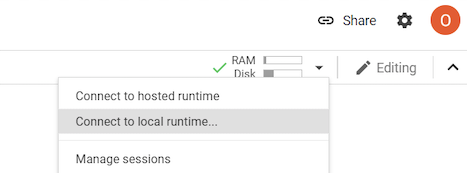

Having connected to the EPI2ME Labs Server, before anything else we will create and set a working directory:

In [ ]:
# create a work directory and move into it
directory = "fastq_tutorial"
working_dir='/epi2melabs/{}/'.format(directory)
!mkdir -p "$working_dir"
%cd "$working_dir"

from epi2melabs import ping
pinger = ping.Pingu()
pinger.send_notebook_ping('stop', 'fastq_introduction')

# Download sample data
bucket = "ont-exd-int-s3-euwst1-epi2me-labs"
domain = "s3-eu-west-1.amazonaws.com"
site = "https://{}.{}".format(bucket, domain)

!wget "$site/fast_introduction/archive.tar.gz"
!tar -xzvf archive.tar.gz
%cd test0

The snippets all have their code to the left-hand side and a form to the right which can be used to change their inputs (as an alternative to directly editing the code).

#### How many records in my `.fastq` file?

To count the number of records in a `.fastq` file we can use the linux [word count](https://linux.die.net/man/1/wc) command to count the number of lines in a file, with a division by four accounting for four lines per record:

In [ ]:
filename = "example3.fastq"  #@param {type: "string"}
!echo $(( $(wc -l < $filename) / 4 )) reads

100 reads


#### List all the fastqs in a directory

As Oxford Nanopore Technologies' sequencing devices output multiple `.fastq` files during the course of an experiment, it can be useful to find and list all such files. We can do this with the linux [find](https://linux.die.net/man/1/find) command:

In [ ]:
directory = "." #@param {type: "string"}

!find $directory -name "*.fastq"

./example3.fastq
./fail/example1.fastq
./pass/example2.fastq


The default directory value here (`.`) means "the current working directory."

#### Concatenate all fastqs in a directory into a single file

Many bioinformatics programs require all sequence data to be present in a single `.fastq` file. In order to process sequences across multiple files we must concatenate (or "cat") all the `.fastq` files into a single consolidated file. To perform this task we can use a combination of the linux [find](https://linux.die.net/man/1/find), [xargs](https://linux.die.net/man/1/xargs), and [cat](https://linux.die.net/man/1/cat) commands:

In [ ]:
directory = "." #@param {type: "string"}
output_fastq = "all_records.fastq" #@param {type: "string"}

!find . -type f \( -iname "*.fastq" ! -iname $output_fastq \) | \
    xargs cat > $output_fastq
!echo $(( $(wc -l < $output_fastq) / 4 )) reads

300 reads


Again the default directory value here (`.`) means "the current working directory."

You may often see a simple form of the above:

    cat *.fastq > output.fastq

however, this command will fail if the number of `.fastq` files found is very large.

#### Remove all duplicates in a fastq

In can sometimes be the case that for some reason a `.fastq` file contains duplicates of the same read. To remove these we can use the [`rmdup`](https://bioinf.shenwei.me/seqkit/usage/#rmdup) command of the [seqkit](https://github.com/shenwei356/seqkit) program:

In [ ]:
input_fastq = "all_records.fastq" #@param {type: "string"}
output_fastq = "deduplicated.fastq" #@param {type: "string"}

!seqkit rmdup "$input_fastq" -o "$output_fastq"

[INFO] 200 duplicated records removed


For the example data, 200 duplicate records are identified because the three files (containing 100 records each) are in fact copies of the same file.

#### Compress or extract a fastq file

We can save hard disk space on our computer by compressing `.fastq` files. To do this we recommend using [`bgzip`](http://www.htslib.org/doc/bgzip.html) which allows for indexing and fast retrieval of sequences by bioinformatics programs:

In [ ]:
input_fastq = "example3.fastq" #@param {type: "string"}
compressed_fastq = "example3.fastq.gz" #@param {type: "string"}
!ls -lh "$input_fastq"
!bgzip "$input_fastq"
!ls -lh "$compressed_fastq"

-rw-r--r-- 1 jovyan users 1.8M Apr 21 16:52 example3.fastq
-rw-r--r-- 1 jovyan users 892K May 28 13:55 example3.fastq.gz


The size of the compressed file is roughly half of the original. To decompress the compress file, we again use `bgzip`:

In [ ]:
compressed_fastq = "example3.fastq.gz" #@param {type: "string"}
!bgzip -d "$compressed_fastq"

#### Compress a directory structure

In order to compress a directory structure we can use the linux [`tar`](https://linux.die.net/man/1/tar) command with the compression option: 

In [ ]:
directory = "pass" #@param {type: "string"}
archive = "archive.tar.gz" #@param {type: "string"}

# the options here mean: create, gzip compress, verbose, output file
!tar -czvf "$archive" "$directory"

pass/
pass/example2.fastq


When compressing directories and their contents in this way it is good practice to compress a single top-level directory, so that when the archive is decompressed a single top-level directory is retrieved (and the users working directory isn't polluted).

To decompress the archive we use a similar command:

In [ ]:
archive = "archive.tar.gz" #@param {type: "string"}

# A temporary folder (tmp) is created here simply to avoid confusion with the
# original directory compressed in the previous example. This is not necessary
# in practice.

# the options here mean: extract, gzip compressed, verbose, input file
!rm -rf tmp && mkdir tmp && cd tmp && \
    tar -xzvf ../"$archive"

pass/
pass/example2.fastq


## Visualizing fastq

The snippets below demonstrate basic parsing of fastq data in python. We do not recommend using this code in practice as much of the information is more readily available in the `sequencing_summary.txt` file produced by Oxford Nanopore Technologies' sequencing devices. See our [Basic QC Tutorial](https://colab.research.google.com/github/epi2me-labs/tutorials/blob/master/basic_qc_tutorial.ipynb) for more examples.

In [ ]:
pinger.send_notebook_ping('stop', 'fastq_introduction')

import numpy as np
from pysam import FastxFile
from bokeh.layouts import gridplot

qualities = list()
mean_qualities = list()
lengths = list()

# open the file and iterate through its records
with FastxFile("all_records.fastq") as fq:
    for rec in fq:
        # ONT calculation for "mean Q score"
        quals = np.fromiter(
            (ord(x) - 33 for x in rec.quality),
            dtype=int, count=len(rec.quality))
        mean_p = np.mean(np.power(10, quals/-10))
        mean_qualities.append(-10*np.log10(mean_p))
        # all qualities
        qualities.extend(quals)
        lengths.append(len(quals))

# use the aplanat library to plot some graphs of the
# collected statistics
import aplanat
from aplanat.hist import histogram

p1 = histogram(
    [np.array(mean_qualities)], title="Read quality scores",
    x_axis_label="quality", y_axis_label="count",
    height=250, width=300)
p2 = histogram(
    [qualities], title="Base quality scores",
    x_axis_label="quality", y_axis_label="count",
    height=250, width=300)
p3 = histogram(
    [lengths], title="Read lengths",
    x_axis_label="read length / bases", y_axis_label="count",
    height=250, width=300)
aplanat.show(gridplot((p1, p2, p3), ncols=3))